## Evaluation notebook

### 1. Install / Import

In [17]:
import json
from pdf2image import convert_from_path
from common_utils import encode_image_to_base64, call_gpt_4
from ragas import EvaluationDataset, evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
from ipynb.fs.full.classRag import RAG
from dotenv import load_dotenv
load_dotenv()

True

### 2. Generate QA Set in the correct format

In [22]:
user_input = "Tell me a fun fact about space."
response = call_gpt_4(user_input)

print("GPT-4 Response:", response)


Tell me a fun fact about space.
GPT-4 Response: A fun fact about space is that it is completely silent! Unlike on Earth, where sound travels through air or other mediums, space is a vacuum, meaning there are no molecules to carry sound waves. So if you were to shout in space, no one would hear you!


[{'role': 'system', 'content': 'Only generate question and answer pairs based on the content of this image. Output 2 pairs. Nothing else.'}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Generate 2 question and answer pairs based on the content of this page.'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]

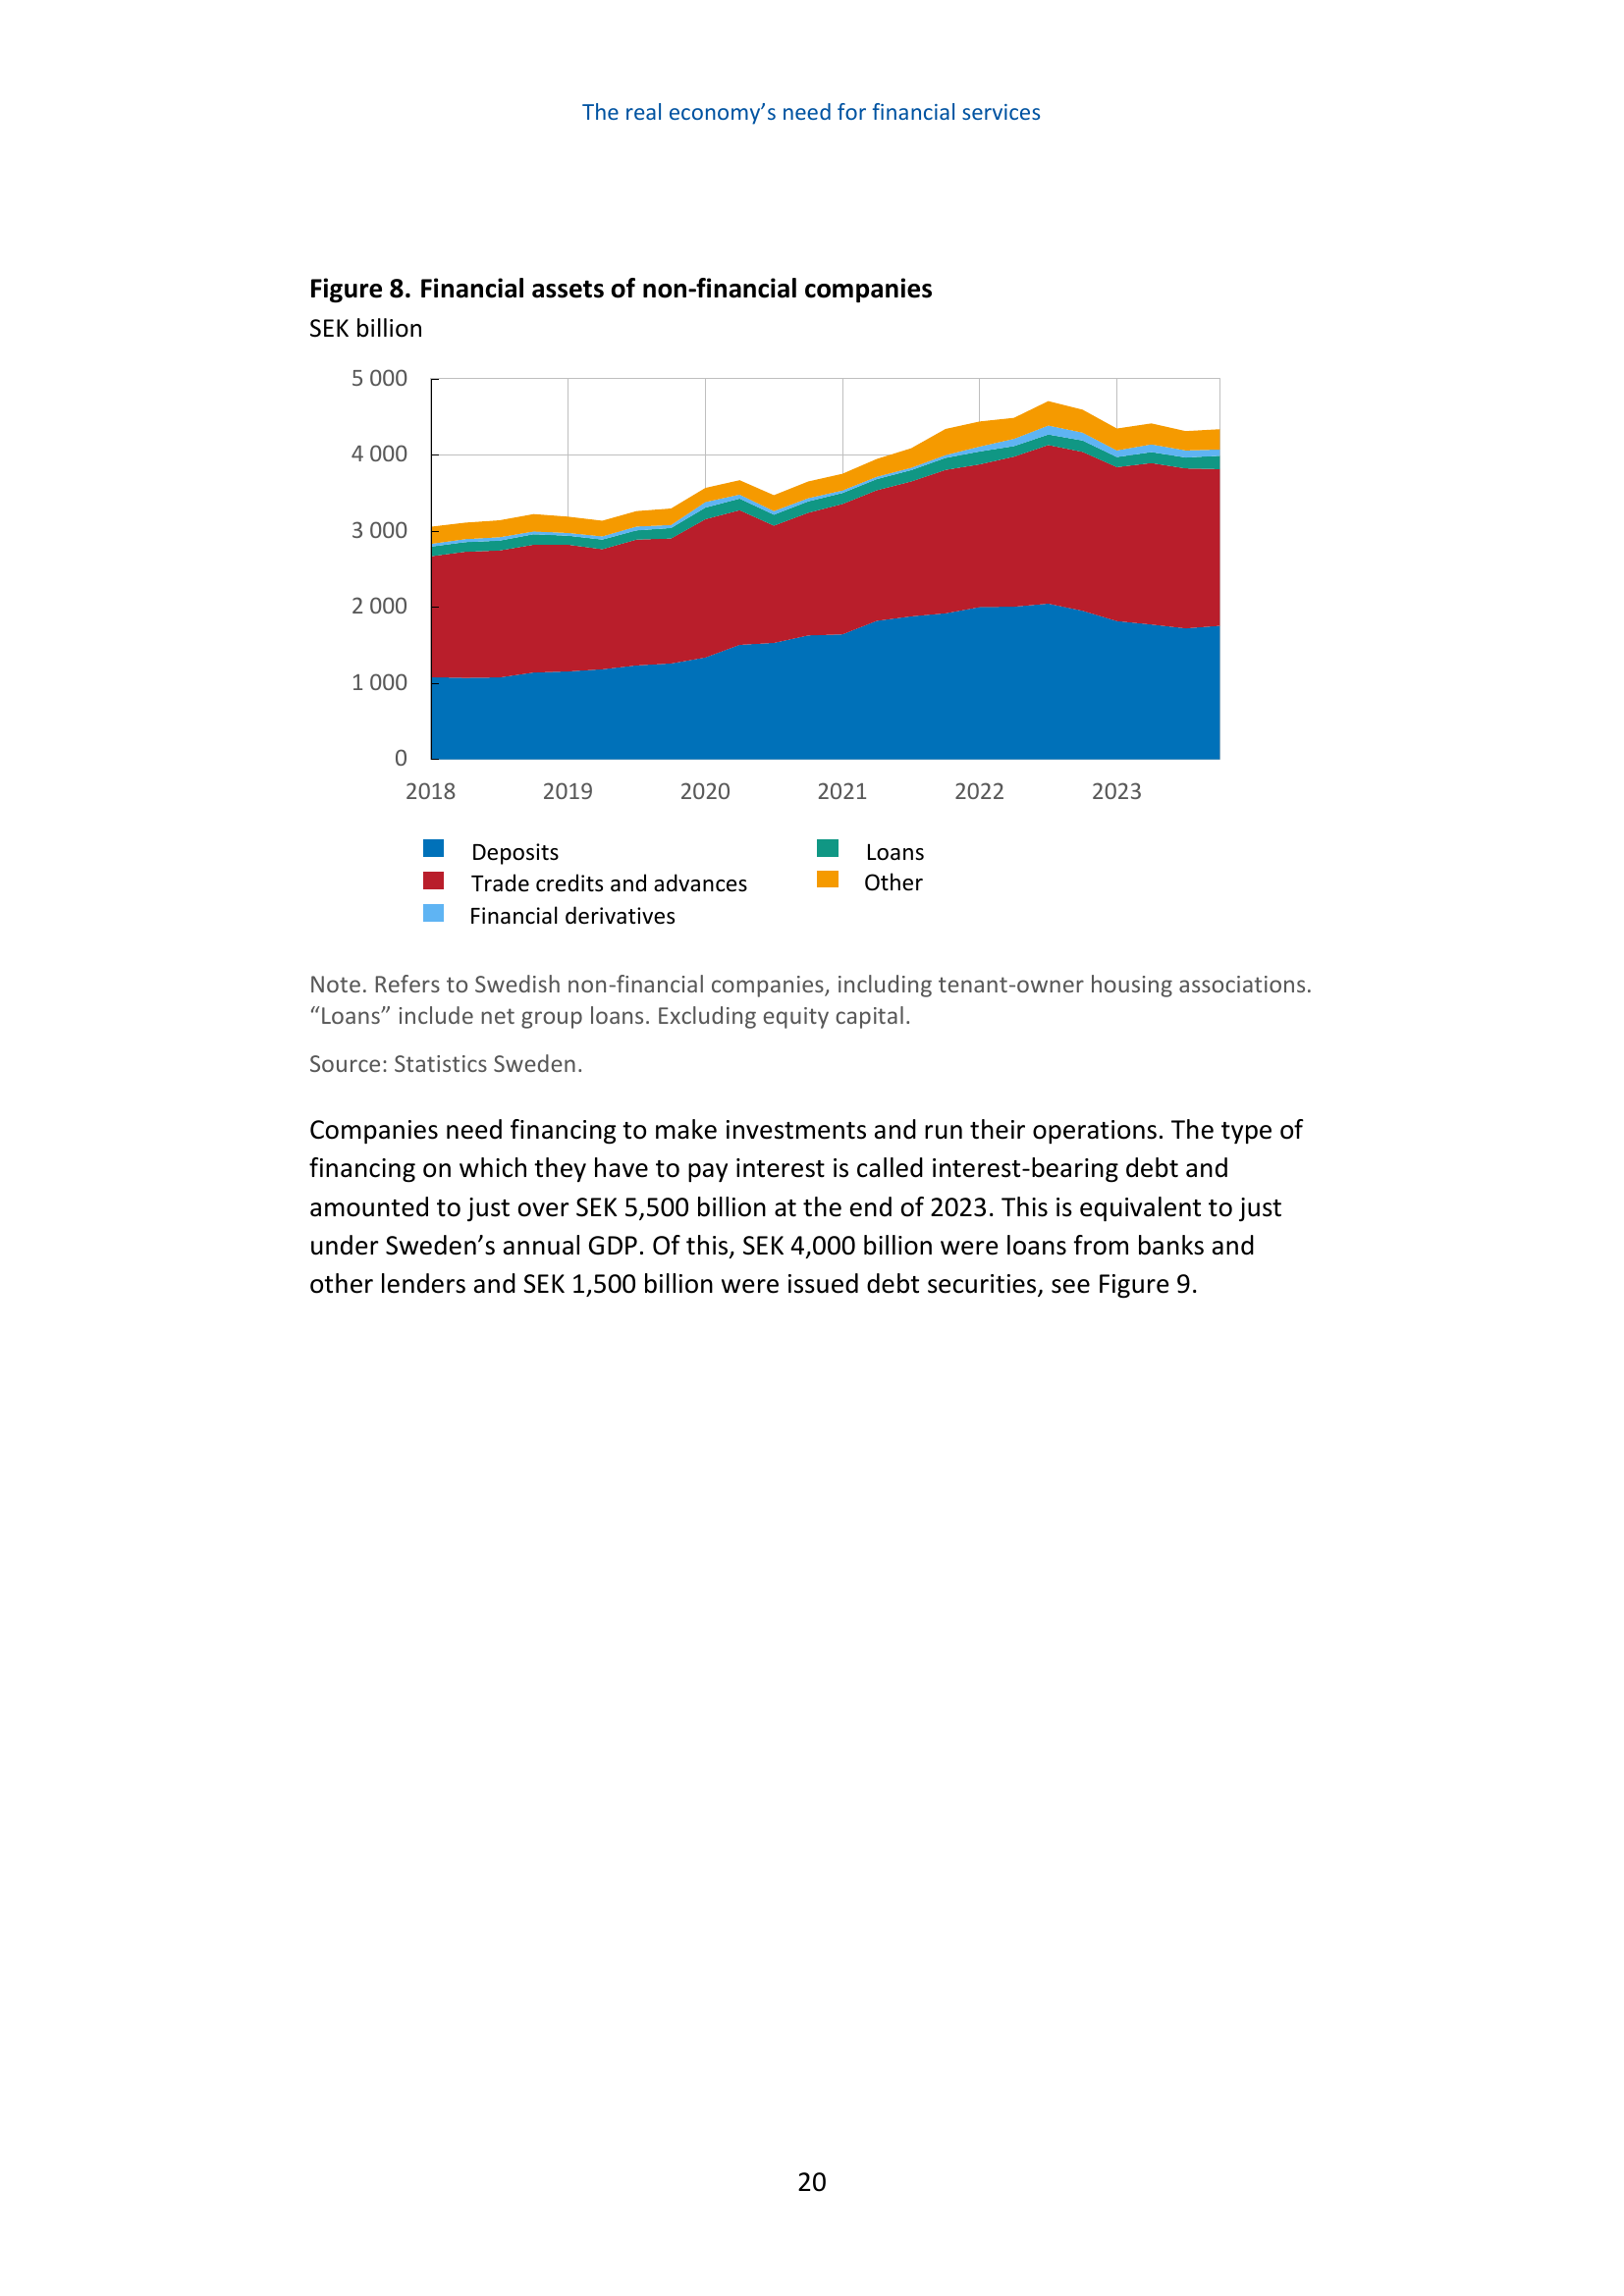

BadRequestError: Error code: 400 - {'error': {'message': "Missing required parameter: 'messages[1].content[0].type'.", 'type': 'invalid_request_error', 'param': 'messages[1].content[0].type', 'code': 'missing_required_parameter'}}

In [20]:
def generate_qa_for_pdf(pdf_path):
    output_json = "QA_" + pdf_path.split('/')[-1].replace('.pdf', '.json')
    pages = convert_from_path(pdf_path, dpi=200, poppler_path='/opt/homebrew/bin')
    
    for i, page_image in enumerate(pages, start=1):
        base64_str = encode_image_to_base64(page_image)
        messages = [
            {"role": "system", 
             "content": "Only generate question and answer pairs based on the content of this image. Output 2 pairs. Nothing else."
             },
            {
                "role": "user", 
                "content": [
                {"type": "text", "text": "Generate 2 question and answer pairs based on the content of this page."},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_str}"}}
            ]}
        ]
        response_text = call_gpt_4(messages)
        response_text = "call_gpt_4(messages)"
        record = {"page_number": i, "qa_text": response_text}
        
        with open(output_json, 'a', encoding='utf-8') as f:
            f.write(json.dumps(record, ensure_ascii=False))
            f.write("\n")
        
        print(f"\n--- Q&A for page {i} ---\n{response_text}\n")
        #print(f"Appended results for page {i} to {output_json}")

generate_qa_for_pdf("../knowledge/subset_monetary_policy_report.pdf")

[{'role': 'system', 'content': 'Only generate question and answer pairs based on the content of this image. Output 10 pairs. Nothing else.'}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Generate 10 question and answer pairs based on the content of this page.'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]

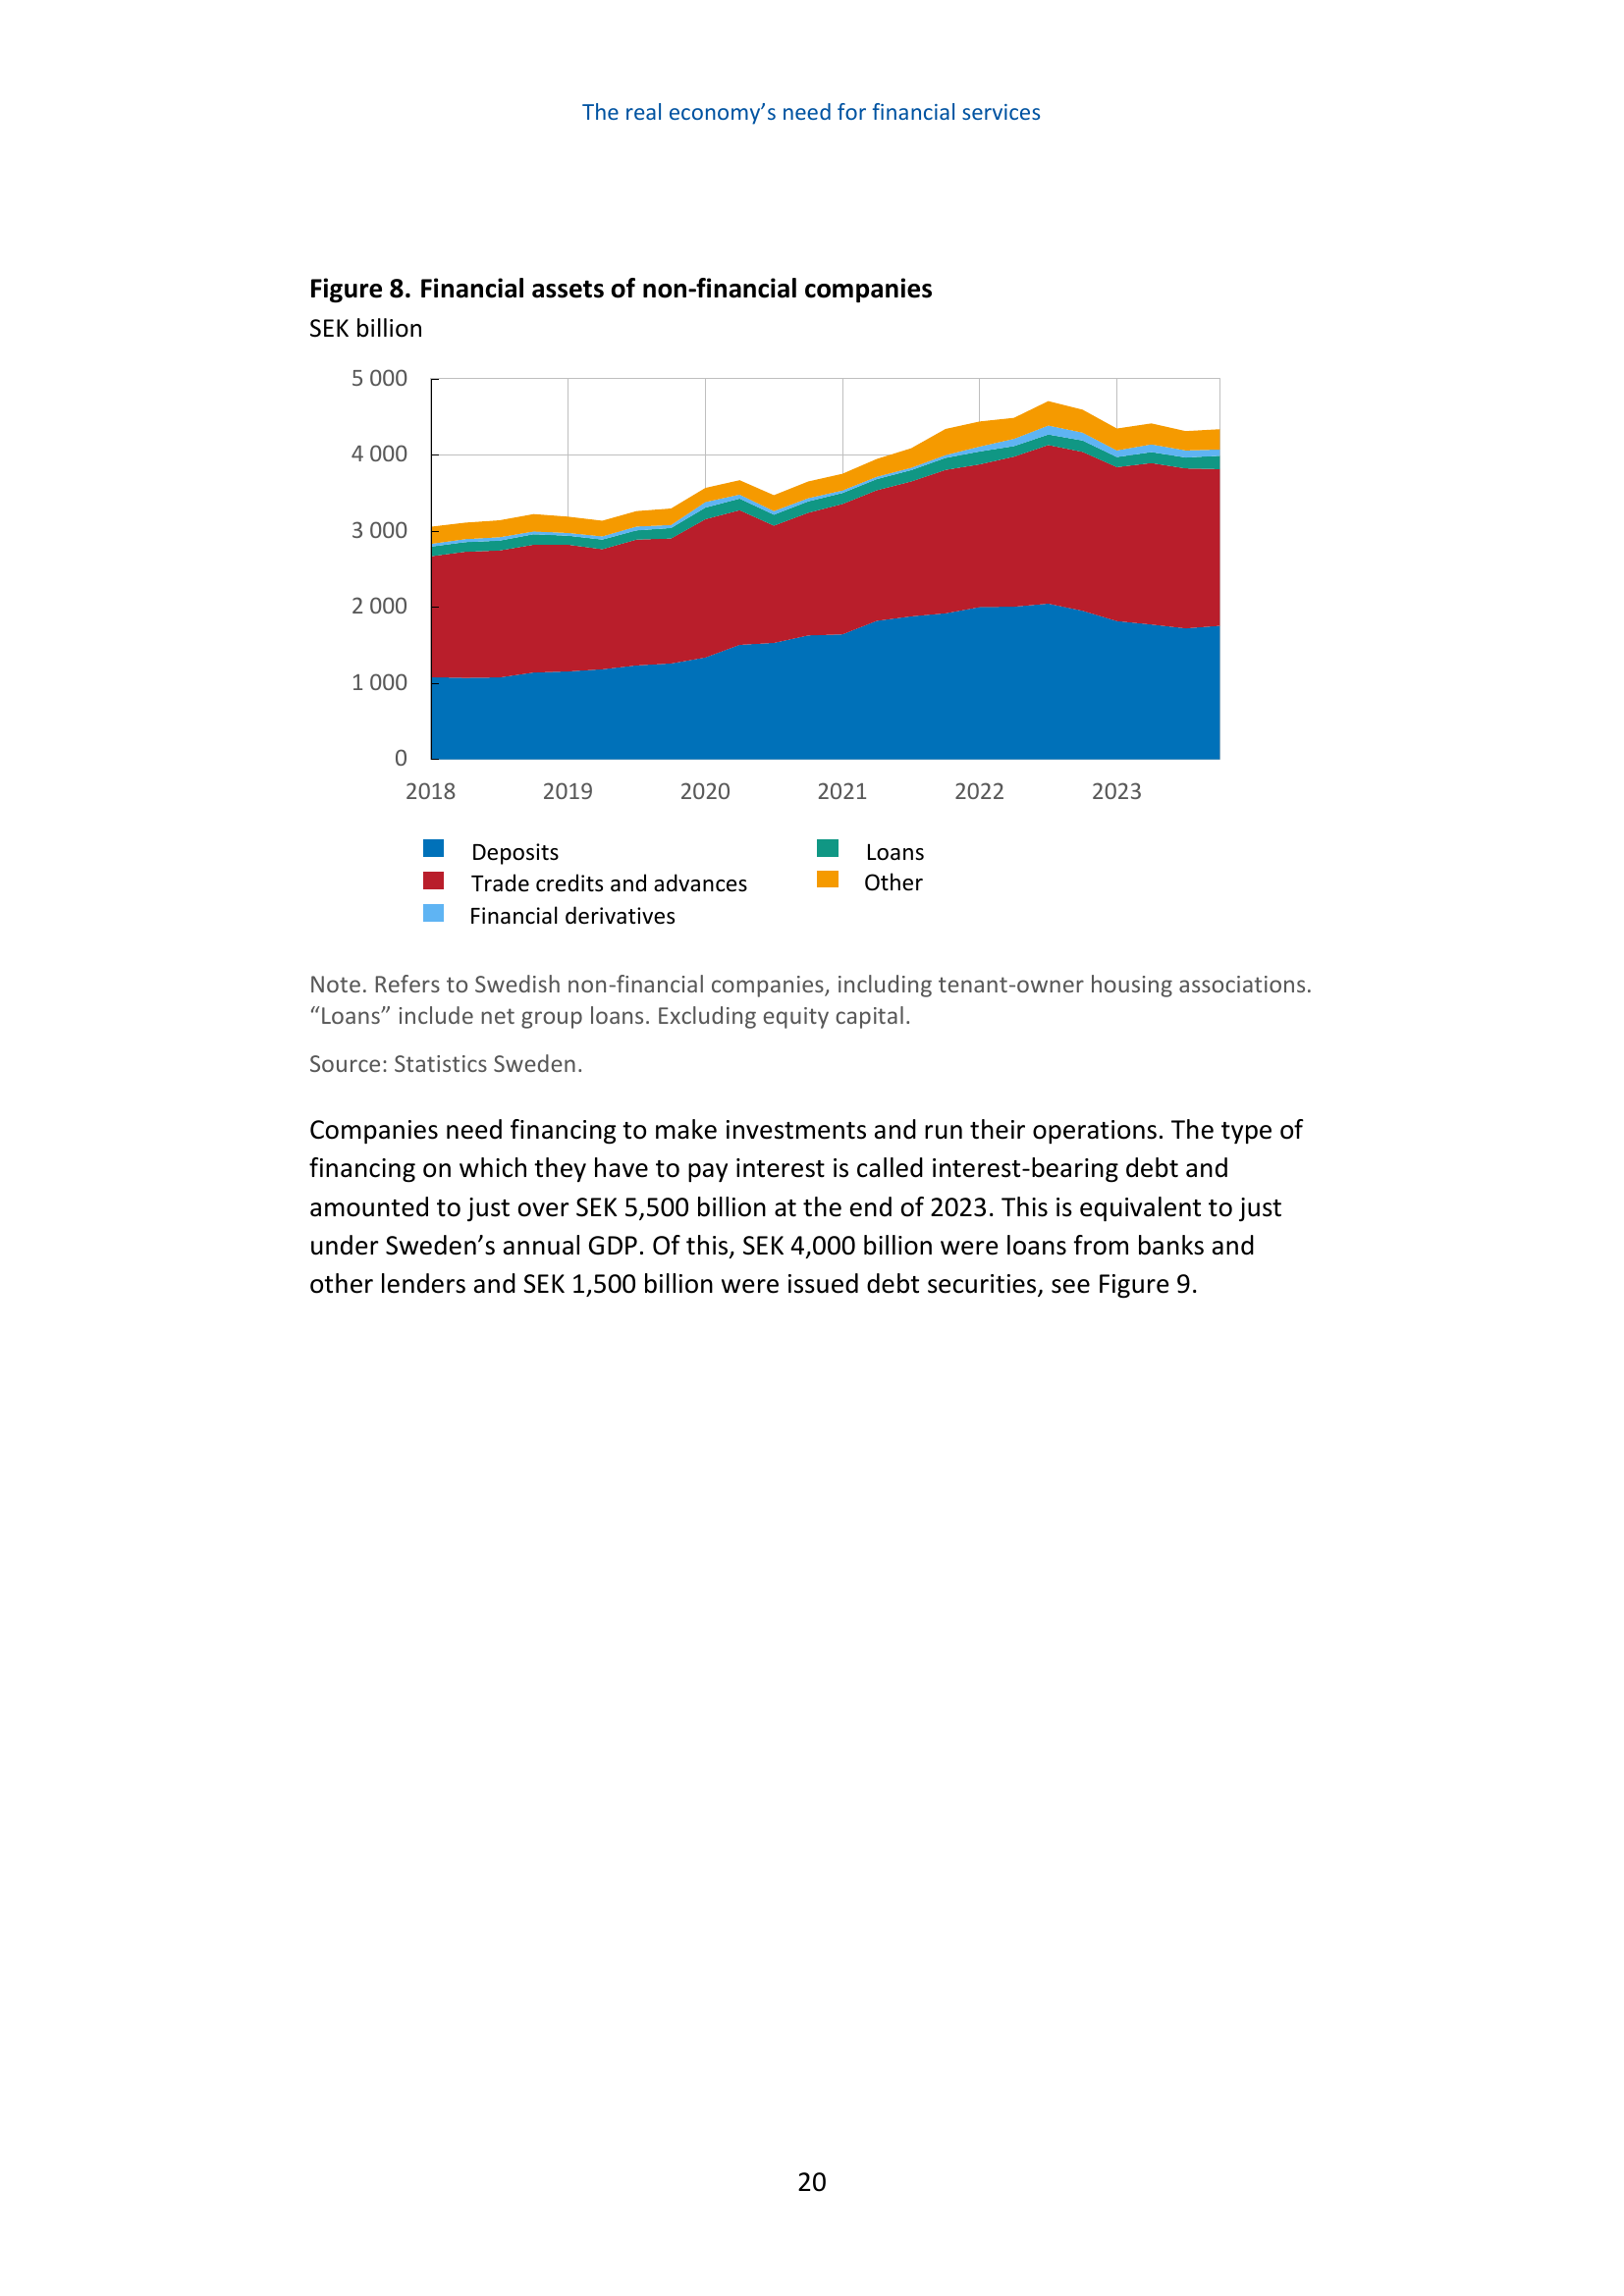

BadRequestError: Error code: 400 - {'error': {'message': "Missing required parameter: 'messages[1].content[0].type'.", 'type': 'invalid_request_error', 'param': 'messages[1].content[0].type', 'code': 'missing_required_parameter'}}

In [21]:

def generate_qa_for_pdf(pdf_path):
    """
    Convert each PDF page to an image, then for each image:
    - Encode as base64
    - Call GPT-4 to generate Q&A pairs
    - Immediately append the result to an NDJSON/JSONL file (one JSON object per line),
      so we don't keep everything in memory for large PDFs.
    """
    
    # Output file
    output_json = "QA_" + pdf_path.split('/')[-1].replace('.pdf', '.json')

    # 1. Convert PDF pages to images
    # pages = convert_from_path(PDF_FILE, dpi=200, poppler_path=r'../poppler-24.08.0/Library/bin')
    pages = convert_from_path(PDF_FILE, dpi=200, poppler_path='/opt/homebrew/bin')


    # 2. Process each page, one at a time
    for i, page_image in enumerate(pages, start=1):
        # Encode page as base64
        base64_str = encode_image_to_base64(page_image)

        # Prompt GPT-4. For example, ask it for 10 Q&A pairs:
        messages = [
            {
                "role": "system",
                "content": "Only generate question and answer pairs based on the content of this image. Output 10 pairs. Nothing else."
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Generate 10 question and answer pairs based on the content of this page."},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_str}"}}
                ]
            }
        ]

        response_text = call_gpt_4(messages)

        # Prepare the record for this page
        record = {
            "page_number": i,
            "qa_text": response_text
        }

        # 3. Append record to the JSON file in NDJSON/JSONL format
        #    (one JSON object per line)
        with open(output_json, 'a', encoding='utf-8') as f:
            f.write(json.dumps(record, ensure_ascii=False))
            f.write("\n")

        print(f"\n--- Q&A for page {i} ---\n{response_text}\n")
        print(f"Appended results for page {i} to {output_json}")

if __name__ == "__main__":
    PDF_FILE = "../knowledge/subset_monetary_policy_report.pdf"
    generate_qa_for_pdf(pdf_path=PDF_FILE)